<a href="https://colab.research.google.com/github/DhrubaAdhikary/ERA_V2/blob/master/S7/ERA1_S7_step1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

## Loading Models

In [5]:
!pip install torchsummary
!git clone https://github.com/DhrubaAdhikary/ERA_V2.git -q --quiet
!mv ERA_V2/S7/*.py .
!rm -rf ERA1

fatal: destination path 'ERA_V2' already exists and is not an empty directory.


## Step 1
### Target
1. Create a Setup (dataset, data loader, train/test steps and log plots)
2. Defining simple model with Convolution block, GAP.


In [6]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations


In [7]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [8]:
train = datasets.MNIST('./data', train=True, download = True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 113154895.70it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 34442904.13it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30074584.91it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20843029.29it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Dataloader Arguments & Test/Train Dataloaders

In [9]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Availalbe?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle=True,batch_size=128,num_workers=4,pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Availalbe? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Model

In [10]:
from model import Model_1
Net = Model_1

## Model Params

In [11]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

## Training and Testing

In [12]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [13]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.09317509084939957 Batch_id=468 Accuracy=91.01: 100%|██████████| 469/469 [00:23<00:00, 19.69it/s]



Test set: Average loss: 0.0834, Accuracy: 9750/10000 (97.50%)

EPOCH: 1


Loss=0.05897800251841545 Batch_id=468 Accuracy=97.15: 100%|██████████| 469/469 [00:17<00:00, 27.24it/s]



Test set: Average loss: 0.0523, Accuracy: 9825/10000 (98.25%)

EPOCH: 2


Loss=0.06262733042240143 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:16<00:00, 28.28it/s]



Test set: Average loss: 0.0482, Accuracy: 9853/10000 (98.53%)

EPOCH: 3


Loss=0.009485719725489616 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:17<00:00, 27.56it/s]



Test set: Average loss: 0.0451, Accuracy: 9843/10000 (98.43%)

EPOCH: 4


Loss=0.04895540699362755 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:16<00:00, 28.51it/s]



Test set: Average loss: 0.0399, Accuracy: 9868/10000 (98.68%)

EPOCH: 5


Loss=0.023100048303604126 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:17<00:00, 27.47it/s]



Test set: Average loss: 0.0419, Accuracy: 9862/10000 (98.62%)

EPOCH: 6


Loss=0.09110390394926071 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:16<00:00, 28.35it/s]



Test set: Average loss: 0.0379, Accuracy: 9889/10000 (98.89%)

EPOCH: 7


Loss=0.05523577332496643 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:17<00:00, 27.44it/s]



Test set: Average loss: 0.0323, Accuracy: 9895/10000 (98.95%)

EPOCH: 8


Loss=0.013046112842857838 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:17<00:00, 27.10it/s]



Test set: Average loss: 0.0364, Accuracy: 9879/10000 (98.79%)

EPOCH: 9


Loss=0.015117835253477097 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:16<00:00, 27.68it/s]



Test set: Average loss: 0.0345, Accuracy: 9880/10000 (98.80%)

EPOCH: 10


Loss=0.06486942619085312 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:16<00:00, 28.31it/s]



Test set: Average loss: 0.0339, Accuracy: 9889/10000 (98.89%)

EPOCH: 11


Loss=0.014857932925224304 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:16<00:00, 28.66it/s]



Test set: Average loss: 0.0311, Accuracy: 9900/10000 (99.00%)

EPOCH: 12


Loss=0.027071384713053703 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:16<00:00, 28.73it/s]



Test set: Average loss: 0.0305, Accuracy: 9902/10000 (99.02%)

EPOCH: 13


Loss=0.06629877537488937 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:16<00:00, 28.45it/s]



Test set: Average loss: 0.0310, Accuracy: 9906/10000 (99.06%)

EPOCH: 14


Loss=0.004839295521378517 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:16<00:00, 28.32it/s]



Test set: Average loss: 0.0322, Accuracy: 9897/10000 (98.97%)



Text(0.5, 1.0, 'Test Accuracy')

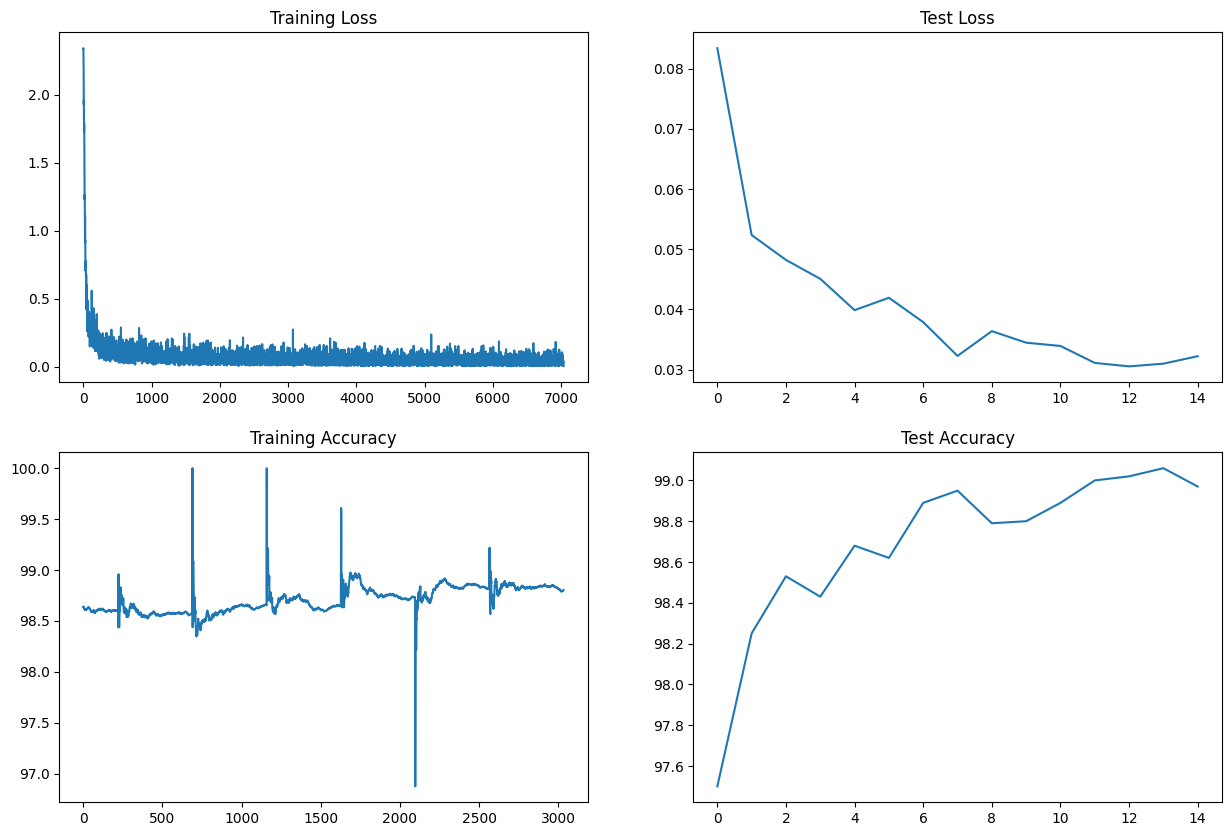

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")